In [1]:
# Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format
import warnings
warnings.filterwarnings('ignore')

# [Working with Stock Market Data](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#working-with-stock-market-data)

In [2]:
# download data and perform the dataframe
prices = (yf.download(
    tickers="AAPL",
    start="2000-01-01",
    end="2022-12-31",
    ignore_tz=True,
    progress=False
)
.reset_index()
.assign(symbol="AAPL")
.rename(columns={
    "Date": "date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Adj Close": "adjusted",
    "Volume": "volume"}
    )
)
prices.head().round(4)

,date,open,high,low,close,adjusted,volume,symbol
0,2000-01-03,0.9364,1.0045,0.9079,0.9994,0.8461,535796800,AAPL
1,2000-01-04,0.9665,0.9877,0.9035,0.9152,0.7748,512377600,AAPL
2,2000-01-05,0.9263,0.9872,0.9196,0.9286,0.7861,778321600,AAPL
3,2000-01-06,0.9475,0.9554,0.8482,0.8482,0.7181,767972800,AAPL
4,2000-01-07,0.8616,0.9018,0.8527,0.8884,0.7521,460734400,AAPL


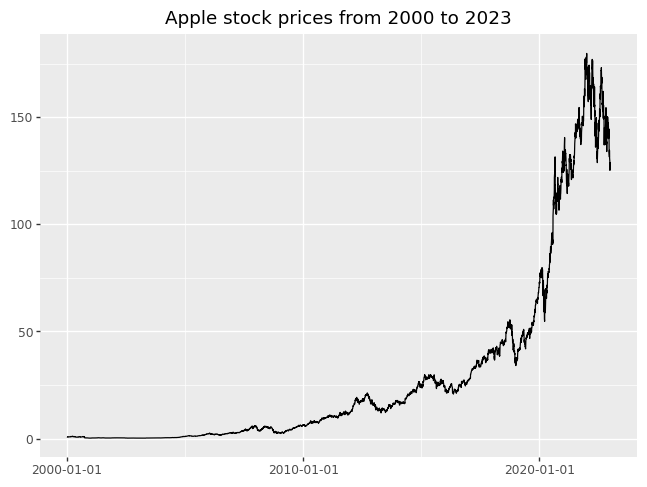

In [3]:
# visualize stock prices
prices_figure = (
    ggplot(prices, aes(y="adjusted", x="date")) +
    geom_line() +
    labs(x="", y="",
         title="Apple stock prices from 2000 to 2023")
)
prices_figure.draw()

In [4]:
# returns percentage change
returns = (prices
    .sort_values("date")
    .assign(ret=lambda x: x["adjusted"].pct_change())
    .get(["symbol", "date", "ret"])
)
returns = returns.dropna()
returns.head().round(4)

,symbol,date,ret
1,AAPL,2000-01-04,-0.0843
2,AAPL,2000-01-05,0.0146
3,AAPL,2000-01-06,-0.0865
4,AAPL,2000-01-07,0.0474
5,AAPL,2000-01-10,-0.0176


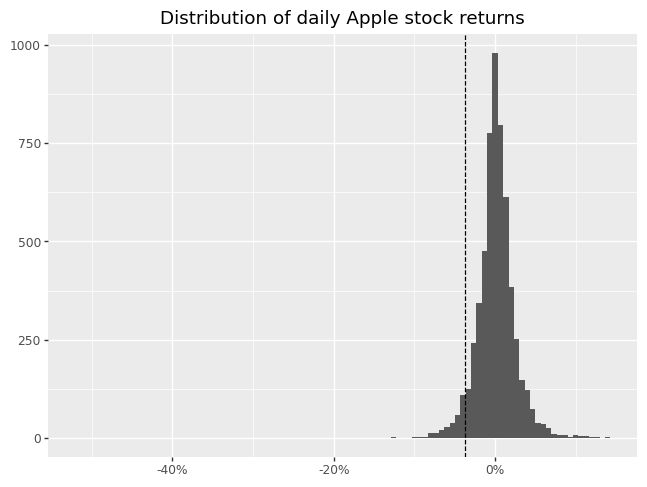

In [5]:
# determine the fifth 5 percent quartile to determine the VaR
quantile_05 = returns["ret"].quantile(0.05)
returns_figure = (
    ggplot(returns, aes(x="ret")) +
    geom_histogram(bins=100) +
    geom_vline(aes(xintercept=quantile_05),
               linetype="dashed") +
    labs(x="", y="",
         title="Distribution of daily Apple stock returns") +
    scale_x_continuous(labels=percent_format())
)
returns_figure.draw()

In [6]:
# statistics for total returns
pd.DataFrame(returns["ret"].describe()).round(3).T

,count,mean,std,min,25%,50%,75%,max
ret,5786.0,0.001,0.025,-0.519,-0.01,0.001,0.013,0.139


In [7]:
# Annualized
pd.DataFrame(returns["ret"]
    .groupby(returns["date"].dt.year)
    .describe()
).round(3)

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2000,251.0,-0.003,0.055,-0.519,-0.034,-0.002,0.027,0.137
2001,248.0,0.002,0.039,-0.172,-0.023,-0.001,0.027,0.129
2002,252.0,-0.001,0.031,-0.150,-0.019,-0.003,0.018,0.085
2003,252.0,0.002,0.023,-0.081,-0.012,0.002,0.015,0.113
2004,252.0,0.005,0.025,-0.056,-0.009,0.003,0.016,0.132
2005,252.0,0.003,0.024,-0.092,-0.010,0.003,0.017,0.091
2006,251.0,0.001,0.024,-0.063,-0.014,-0.002,0.014,0.118
2007,251.0,0.004,0.024,-0.070,-0.009,0.003,0.018,0.105
2008,253.0,-0.003,0.037,-0.179,-0.024,-0.001,0.019,0.139


# [Scaling Up the Analysis](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#scaling-up-the-analysis)

In [8]:
# donwload the symbols that make up the Dow Jones index
url = ("https://www.ssga.com/us/en/institutional/etfs/library-content/"
       "products/fund-data/etfs/us/holdings-daily-us-en-dia.xlsx")
symbols = (pd.read_excel(url, skiprows=4, nrows=30)
       .get("Ticker")
       .tolist()
)

In [9]:
# download data and perform the dataframe from wide format to long format
index_prices = (yf.download(
    tickers=symbols, 
    start="2000-01-01", 
    end="2023-12-31", 
    progress=False
  )
  .melt(ignore_index=False)
  .reset_index()
  .pivot(index=["Date", "Ticker"], columns="Price", values="value")
  .reset_index()
  .rename(columns={
    "Date": "date", 
    "Ticker": "symbol",
    "Open": "open", 
    "High": "high", 
    "Low": "low",
    "Close": "close", 
    "Adj Close": "adjusted", 
    "Volume": "volume"}
  )
)
index_prices.columns.name = None

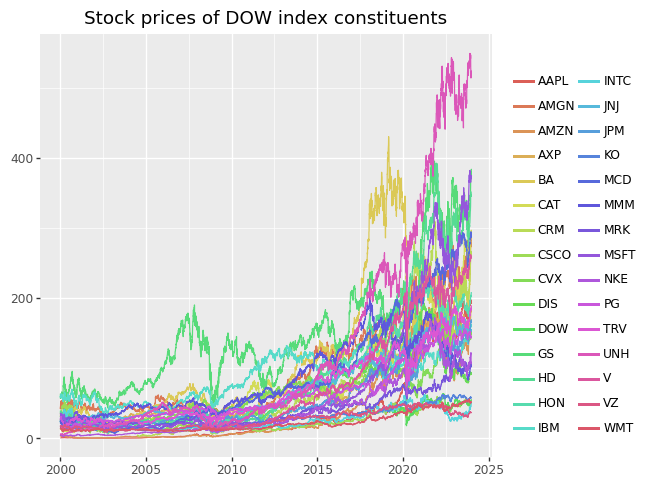

In [10]:
# visualize each DOW's stock prices
index_prices_figure = (
    ggplot(index_prices,
           aes(y="adjusted", x="date", color="symbol")) +
           geom_line() +
           labs(x="", y="", color="",
                title="Stock prices of DOW index constituents") +
            scale_x_datetime(date_breaks="5 years", date_labels="%Y") +
            theme(legend_position="right",
                legend_box_margin=0,
                legend_key=element_blank())
)
index_prices_figure.draw()

In [11]:
# calculate total return and show statistics
all_returns = (index_prices
    .assign(ret=lambda x: x.groupby("symbol")["adjusted"].pct_change(fill_method=None))
    .get(["symbol", "date", "ret"])
    .dropna(subset="ret")
)
(all_returns
  .groupby("symbol")["ret"]
  .describe()
  .round(3)
)

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
AAPL,6036.0,0.001,0.025,-0.519,-0.010,0.001,0.013,0.139
AMGN,6036.0,0.000,0.019,-0.134,-0.009,0.000,0.009,0.151
AMZN,6036.0,0.001,0.032,-0.248,-0.012,0.000,0.014,0.345
AXP,6036.0,0.001,0.023,-0.176,-0.009,0.000,0.010,0.219
BA,6036.0,0.001,0.022,-0.238,-0.010,0.001,0.011,0.243
CAT,6036.0,0.001,0.020,-0.145,-0.010,0.001,0.011,0.147
CRM,4914.0,0.001,0.027,-0.271,-0.012,0.001,0.014,0.260
CSCO,6036.0,0.000,0.023,-0.162,-0.009,0.000,0.010,0.244
CVX,6036.0,0.001,0.018,-0.221,-0.008,0.001,0.009,0.227


# [Other Forms of Data Aggregation](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#other-forms-of-data-aggregation)

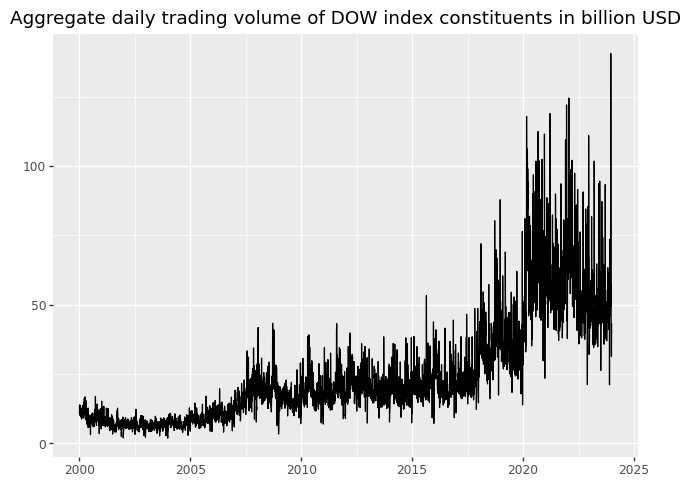

In [12]:
# trading volume in USD
trading_volume = (index_prices
    .assign(trading_volume=lambda x: (x["volume"]*x["adjusted"])/1e9)
    .groupby("date")["trading_volume"]
    .sum()
    .reset_index()
    .assign(trading_volume_lag=lambda x: x["trading_volume"].shift(periods=1))
    .dropna()
)

trading_volume_figure = (
    ggplot(trading_volume,
           aes(x="date", y="trading_volume")) +
    geom_line() +
    labs(x="", y="",
         title=("Aggregate daily trading volume of DOW index constituents "
                "in billion USD")) +
    scale_x_datetime(date_breaks="5 years", date_labels="%Y")
)
trading_volume_figure.draw()

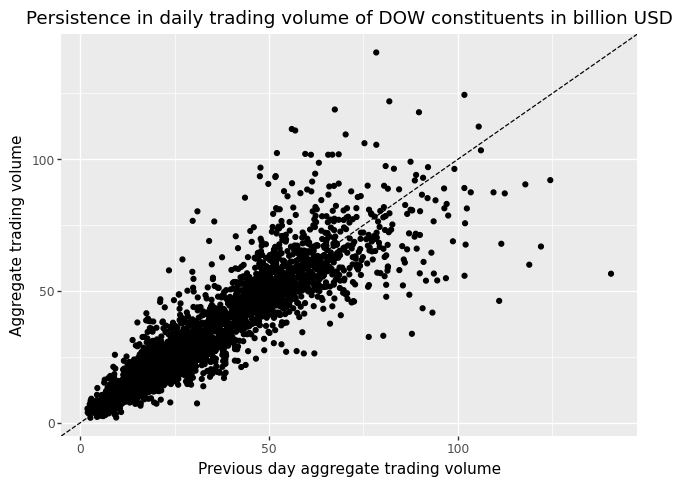

In [13]:
# plot volume on day t against volume on day t - 1
trading_volume_figure_lagged = (
    ggplot(trading_volume,
        aes(x="trading_volume_lag", y="trading_volume")) +
    geom_point() +
    geom_abline(aes(intercept=0, slope=1), linetype="dashed") +
    labs(x="Previous day aggregate trading volume",
         y="Aggregate trading volume",
         title=("Persistence in daily trading volume of DOW constituents "
                "in billion USD"))
)
trading_volume_figure_lagged.draw()

# [Portfolio Choice Problems](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#portfolio-choice-problems)

In [14]:
# prepare dataframe for visualize the efficient frontier
index_prices['counts'] = (index_prices
    .groupby("symbol")["adjusted"]
    .transform(lambda x: x.dropna().count())
)
prices = index_prices[index_prices['counts'] == index_prices['counts'].max()].copy()
returns_matrix = (prices
    .pivot(columns="symbol", values="adjusted", index="date")
    .resample("ME")
    .last()
    .pct_change()
    .dropna()
)
# mean and covariance of returns
mu = np.array(returns_matrix.mean()).T
sigma = np.array(returns_matrix.cov())

In [15]:
# calculate MVP (Minimum Variance Portfolio)
N = returns_matrix.shape[1]
iota = np.ones(N)
sigma_inv = np.linalg.inv(sigma)
# minimum variance portfolio weights
mvp_weights = sigma_inv @ iota
mvp_weights = mvp_weights/mvp_weights.sum()
# expected return of minimum variance portfolio
mvp_return = mu.T @ mvp_weights
# volatility of minimum variance portfolio
mvp_volatility = np.sqrt(mvp_weights.T @ sigma @ mvp_weights)
mvp_moments = pd.DataFrame ({"value": [mvp_return, mvp_volatility]},
                            index=["average_ret", "volatitlity"])
mvp_moments.round(3)

,value
average_ret,0.008
volatitlity,0.032


In [16]:
# minimum acceptable expected return (for example, 3%)
benchmark_multiple = 3
mu_bar = benchmark_multiple * mvp_return
C = iota.T @ sigma_inv @ iota
D = iota.T @ sigma_inv @ mu
E = mu.T @ sigma_inv @ mu
lambda_tilde = 2 * (mu_bar - D / C) / (E - D ** 2 / C)
efp_weights = mvp_weights + lambda_tilde / 2 * (sigma_inv @ mu - D * mvp_weights)

# [The Efficient Frontier](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#the-efficient-frontier)

In [17]:
# calculate the efficient portfolio
length_year = 12
a = np.arange(-0.4, 2.0, 0.01)
res = pd.DataFrame(columns= ["mu", "sd"], index=a).astype(float)

for i in a:
    w = (1 - i) * mvp_weights + i * efp_weights
    res.loc[i, "mu"] = (w.T @ mu) * length_year
    res.loc[i, "sd"] = np.sqrt(w.T @ sigma @ w) * np.sqrt(length_year)

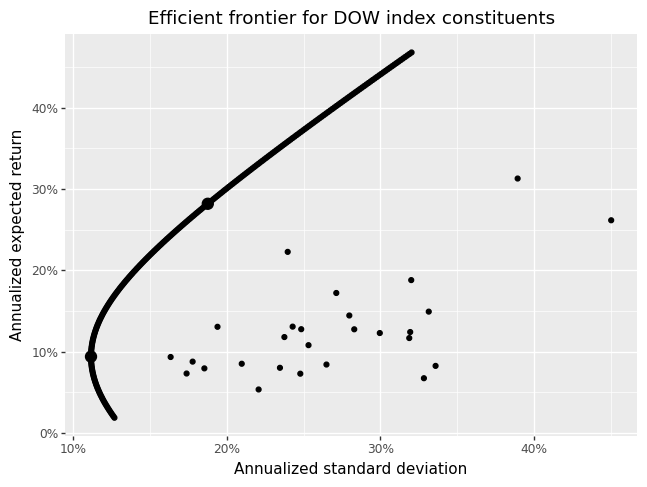

In [18]:
# visualize efficient frontier
mvp_return = (mu.T @ mvp_weights) * length_year
mvp_volatility = (np.sqrt(mvp_weights.T @ sigma @ mvp_weights) *
                        np.sqrt(length_year))
efp_return = mu_bar * length_year
efp_volatility = (np.sqrt(efp_weights.T @ sigma @ efp_weights) *
                        np.sqrt(length_year))
returns_figure = (
    ggplot(res, aes(x="sd", y="mu")) +
    geom_point() +
    geom_point(
        pd.DataFrame({"mu": [mvp_return, efp_return],
                      "sd": [mvp_volatility, efp_volatility]}),
        size=4
    ) +
    geom_point(
        pd.DataFrame({"mu": mu*length_year,
                      "sd": np.sqrt(np.diag(sigma))*np.sqrt(length_year)})
    ) +
    labs(x="Annualized standard deviation",
         y="Annualized expected return",
         title="Efficient frontier for DOW index constituents") +
    scale_x_continuous(labels=percent_format()) +
    scale_y_continuous(labels=percent_format())
)
returns_figure.draw()

# [Exercises](https://www.tidy-finance.org/python/introduction-to-tidy-finance.html#exercises)

### 1.

In [19]:
# Download Airbus data
prices = (yf.download(
    tickers="AIR.DE",
    start="2000-01-01",
    end="2023-12-31",
    ignore_tz=True,
    progress=False
)
.reset_index()
.assign(symbol="AIR.DE")
.rename(columns={
    "Date": "date",
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Adj Close": "adjusted",
    "Volume": "volume"}
    )
)
prices.head().round(4)

,date,open,high,low,close,adjusted,volume,symbol
0,2000-01-03,17.78,17.78,17.78,17.78,12.4309,0,AIR.DE
1,2000-01-04,17.78,17.78,17.78,17.78,12.4309,0,AIR.DE
2,2000-01-05,17.78,17.78,17.78,17.78,12.4309,0,AIR.DE
3,2000-01-06,17.78,17.78,17.78,17.78,12.4309,0,AIR.DE
4,2000-01-07,17.78,17.78,17.78,17.78,12.4309,0,AIR.DE


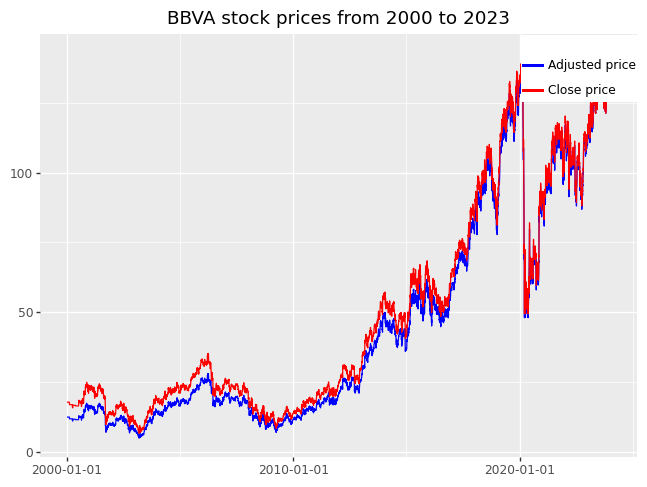

In [20]:
prices_figure = (
    ggplot(prices, aes(x="date")) +
    geom_line(aes(y="adjusted", color="'adjusted'")) +
    geom_line(aes(y="close", color="'close'")) +
    scale_color_manual(values=["blue", "red"],
                       name=" ",
                       labels=["Adjusted price", "Close price"]) +
    labs(x="", y="", title="BBVA stock prices from 2000 to 2023") +
    theme(legend_position=(1, 1),
          legend_box_margin=0,
          legend_key=element_blank())
)
prices_figure.draw()

There are no major differences between the "adjusted" price and the "closing" price, perhaps due to the lack of splits or other factors.

### 2.

In [21]:
# returns percentage change
returns = (prices
    .sort_values("date")
    .assign(ret=lambda x: x["adjusted"].pct_change())
    .get(["symbol", "date", "ret"])
)
returns = returns.dropna()
returns.head().round(4)

,symbol,date,ret
1,AIR.DE,2000-01-04,0.0
2,AIR.DE,2000-01-05,0.0
3,AIR.DE,2000-01-06,0.0
4,AIR.DE,2000-01-07,0.0
5,AIR.DE,2000-01-10,0.0


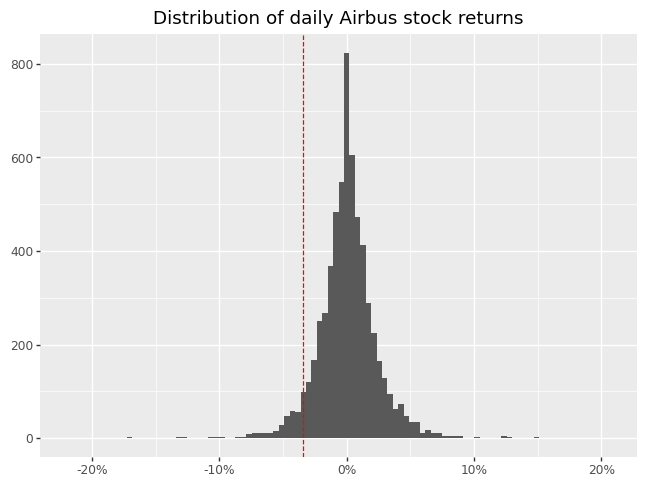

In [22]:
# determine the fifth 5 percent quartile to determine the VaR
quantile_05 = returns["ret"].quantile(0.05)
returns_figure = (
    ggplot(returns, aes(x="ret")) +
    geom_histogram(bins=100) +
    geom_vline(aes(xintercept=quantile_05),
               linetype="dashed", color="red") +
    labs(x="", y="",
         title="Distribution of daily Airbus stock returns") +
    scale_x_continuous(labels=percent_format())
)
returns_figure.draw()

In [23]:
# statistics for total returns
pd.DataFrame(returns["ret"].describe()).round(3).T

,count,mean,std,min,25%,50%,75%,max
ret,6136.0,0.001,0.024,-0.216,-0.011,0.0,0.012,0.207


### 3.

In [24]:
import requests
from bs4 import BeautifulSoup
# get the list of the constituents of the dax 30 are obtained through web scraping
url = f"https://es.finance.yahoo.com/quote/%5EGDAXI/components"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36'
}
response = requests.get(url, headers=headers)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
    div = soup.find("div", class_="Ovx(a) W(100%)")
    table = div.find('table', class_='W(100%) M(0) BdB Bdc($seperatorColor)')
    if table:
        symbols = []
        for row in table.find_all('tr'):
            cells = row.find_all('td', class_='Py(10px) Ta(start) Pend(10px)')
            if cells:
                cell_text = [cell.get_text() for cell in cells]
                symbols.append(cell_text)
        if symbols:
            symbols = [item[0] for item in symbols]

In [25]:
# download data and perform the dataframe from wide format to long format
index_prices = (yf.download(
    tickers=symbols, 
    start="2000-01-01", 
    end="2023-12-31", 
    progress=False
  )
  .melt(ignore_index=False)
  .reset_index()
  .pivot(index=["Date", "Ticker"], columns="Price", values="value")
  .reset_index()
  .rename(columns={
    "Date": "date", 
    "Ticker": "symbol",
    "Open": "open", 
    "High": "high", 
    "Low": "low",
    "Close": "close", 
    "Adj Close": "adjusted", 
    "Volume": "volume"}
  )
)
index_prices.columns.name = None
index_prices = index_prices.dropna()

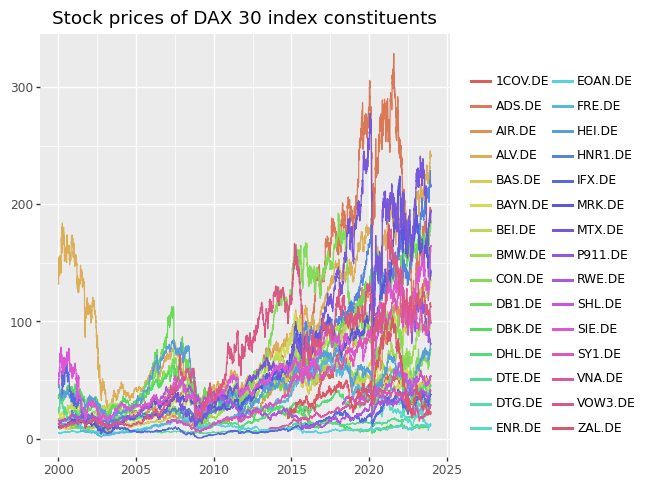

In [26]:
# visualize each DOW's stock prices
index_prices_figure = (
    ggplot(index_prices,
           aes(y="adjusted", x="date", color="symbol")) +
           geom_line() +
           labs(x="", y="", color="",
                title="Stock prices of DAX 30 index constituents") +
            scale_x_datetime(date_breaks="5 years", date_labels="%Y") +
            theme(legend_position="right",
                legend_box_margin=0,
                legend_key=element_blank())
)
index_prices_figure.draw()

In [27]:
# calculate total return and show statistics
all_returns = (index_prices
    .assign(ret=lambda x: x.groupby("symbol")["adjusted"].pct_change(fill_method=None))
    .get(["symbol", "date", "ret"])
    .dropna(subset="ret")
)
(all_returns
  .groupby("symbol")["ret"]
  .describe()
  .round(3)
)

,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
1COV.DE,2094.0,0.001,0.021,-0.156,-0.010,0.000,0.012,0.129
ADS.DE,6136.0,0.001,0.020,-0.154,-0.009,0.000,0.010,0.214
AIR.DE,6136.0,0.001,0.024,-0.216,-0.011,0.000,0.012,0.207
ALV.DE,6136.0,0.000,0.021,-0.153,-0.008,0.000,0.009,0.262
BAS.DE,6136.0,0.000,0.018,-0.136,-0.009,0.000,0.010,0.193
BAYN.DE,6136.0,0.000,0.020,-0.180,-0.009,0.000,0.010,0.391
BEI.DE,6136.0,0.000,0.017,-0.136,-0.007,0.000,0.008,0.134
BMW.DE,6136.0,0.001,0.020,-0.132,-0.010,0.000,0.010,0.148
CON.DE,6136.0,0.001,0.024,-0.204,-0.011,0.000,0.012,0.270


### 4.

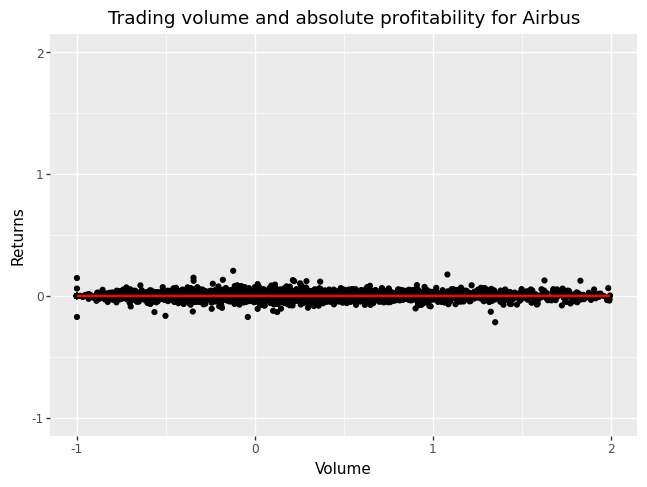

In [28]:
# Are days with high aggregate trading volume often also days with large absolute returns?
airbus = (pd.merge(
        index_prices[index_prices['symbol'] == 'AIR.DE'][["date", "volume"]]
        .assign(vol_pct_change=lambda x: x["volume"].pct_change())
        .drop(columns="volume"),
        all_returns[all_returns['symbol'] == 'AIR.DE'][["date", "ret"]],
        on="date",
        how="inner"
    )
.replace([np.inf, -np.inf], np.nan).dropna(how="any")
)
# Find an appropriate visualization to analyze the question using the ticker AIR.DE
airbus_figure = (
    ggplot(airbus,
           aes(y="ret", x="vol_pct_change")) +
           geom_point() +
           geom_smooth(method='lm', color='red') +
           labs(x="Volume", y="Returns", color="",
                title="Trading volume and absolute profitability for Airbus") +
            xlim(-1.0, 2.0) +
            ylim(-1.0, 2.0)
)
airbus_figure.draw()

As can be seen in the previous graph, there is no positive or negative correlation between the volume traded and the profitability obtained.

In [29]:
# Compute monthly returns from the downloaded stock market prices.
index_prices['counts'] = (index_prices
    .groupby("symbol")["adjusted"]
    .transform(lambda x: x.dropna().count())
)
# exclude ibex 35 constituents for which we do not observe a price on every single trading day
prices = index_prices[index_prices['counts'] == index_prices['counts'].max()].copy()
# monthly returns
returns_matrix = (prices
    .pivot(columns="symbol", values="adjusted", index="date")
    .resample("ME")
    .last()
    .pct_change()
    .dropna()
)
# vector of historical average returns and the sample variance-covariance matrix
mu = np.array(returns_matrix.mean()).T
sigma = np.array(returns_matrix.cov())

In [30]:
N = returns_matrix.shape[1]
iota = np.ones(N)
sigma_inv = np.linalg.inv(sigma)
# minimum variance portfolio weights
mvp_weights = sigma_inv @ iota
mvp_weights = mvp_weights / mvp_weights.sum()
# expected return
mvp_return = mu.T @ mvp_weights
# volatility (monthly)
mvp_volatility = np.sqrt(mvp_weights.T @ sigma @ mvp_weights)
# for visualization
mvp_moments = pd.DataFrame({"value": [mvp_return, mvp_volatility]},
                           index=["average_ret", "volatility"])
mvp_moments.round(3)

,value
average_ret,0.008
volatility,0.041


In [31]:
benchmark_multiple = 3
mu_bar = benchmark_multiple*mvp_return
C = iota.T @ sigma_inv @ iota
D = iota.T @ sigma_inv @ mu
E = mu.T @ sigma_inv @ mu
lambda_tilde = 2*(mu_bar-D/C)/(E-D**2/C)
efp_weights = mvp_weights+lambda_tilde/2*(sigma_inv @ mu-D*mvp_weights)

In [32]:
length_year = 12
limite_inferior = -0.3
limite_superior = 3.0
num_portfolios = [i for i in range(10000)]
res = pd.DataFrame(columns=["mu", "sd"], index=num_portfolios).astype(float)
portfolios_weights = {}
for i in num_portfolios:
    r = limite_inferior + np.random.random() * (limite_superior - limite_inferior)
    w = (1-r)*mvp_weights+r*efp_weights
    res.loc[i, "mu"] = (w.T @ mu)*length_year
    res.loc[i, "sd"] = np.sqrt(w.T @ sigma @ w)*np.sqrt(length_year)
    portfolios_weights[i] = w

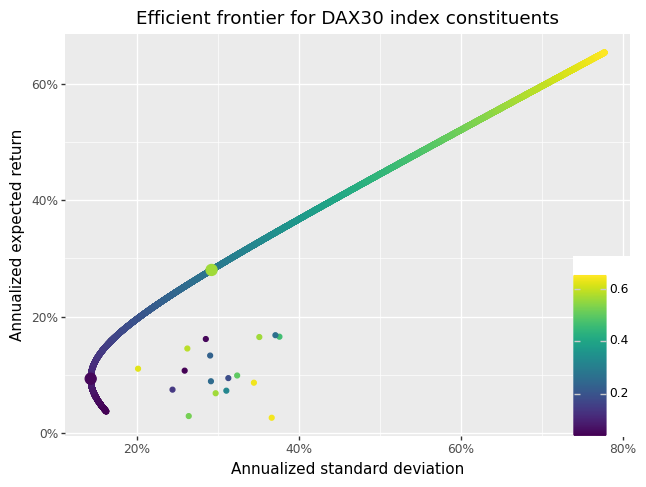

In [33]:
mvp_return = (mu.T @ mvp_weights)*length_year
mvp_volatility = (np.sqrt(mvp_weights.T @ sigma @ mvp_weights)* 
                  np.sqrt(length_year))
efp_return = mu_bar*length_year
efp_volatility = (np.sqrt(efp_weights.T @ sigma @ efp_weights)* 
                  np.sqrt(length_year))

res_figure = (
  ggplot(res, aes(x="sd", y="mu", color="res['mu']")) +
  geom_point() +
  geom_point(
    pd.DataFrame({"mu": [mvp_return, efp_return],
                  "sd": [mvp_volatility, efp_volatility]}),
    size=4
  ) +
  geom_point(
    pd.DataFrame({"mu": mu*length_year,
                  "sd": np.sqrt(np.diag(sigma))*np.sqrt(length_year)})
  ) +
  labs(x="Annualized standard deviation",
       y="Annualized expected return",
       title="Efficient frontier for DAX30 index constituents") +
  scale_x_continuous(labels=percent_format()) +
  scale_y_continuous(labels=percent_format()) +
  theme(legend_position=(1, 0),
          legend_box_margin=0,
          legend_key=element_blank(),
          legend_title=element_text(text=""))
)
res_figure.draw()

In [34]:
# Identify a portfolio for a selected asset with equivalent historical volatility but maximized average return.
random_asset = np.random.choice(returns_matrix.columns)
random_asset_volatility = returns_matrix[random_asset].std() * np.sqrt(length_year)
random_asset_return_annual = returns_matrix[random_asset].sum() * length_year
min_difference_idx = np.abs(res['sd'] - random_asset_volatility).idxmin()
efficient_portfolio_return = res.loc[min_difference_idx, 'mu']
efficient_portfolio_weights = portfolios_weights[min_difference_idx]

### 5.

1. **Survivorship Bias:** By including only those assets that have been consistently traded since 2000, you may introduce survivorship bias into your analysis. This bias occurs because you are excluding those assets that may have ceased trading for any reason, such as poor performance or bankruptcy. Consequently, the results obtained may be overly optimistic, as they are based only on the "survivors".

2. **Market Evolution Effect:** Financial markets have undergone significant changes since the year 2000, including periods of economic growth, recessions, changes in monetary policy, and technological advancements that have affected trading patterns. Limiting attention to assets that have been consistently traded during this period may not provide a complete or accurate picture of the current investment environment.

3. **Missed Investment Opportunities:** By restricting the investment universe to assets that have been consistently traded since 2000, you may miss out on attractive investment opportunities. There are numerous companies and other assets that have launched after 2000 and have provided solid returns to investors.

4. **Prediction Based on Old Data:** Data prior to a certain point may not be relevant to the current market situation, and therefore may not provide a good basis for predicting future performance. For example, economic and market conditions from the year 2000 onwards could be quite different from those today.


### 6.

In [35]:
# Identify the portfolio with the highest expected return per standard deviation.
highest_portfolio = res['mu'].idxmax()
highest_portfolio_weights = portfolios_weights[highest_portfolio]
# Sharpe ratio
sharpe_ratio_highest_portfolio = res.loc[highest_portfolio]['mu'] / res.loc[highest_portfolio]['sd']

**Congratulations, end of the introduction!**